# Trénovanie modelu na základe DST indexu 1h dopredu 6h dozadu

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

In [4]:
#!pip install tensorflow==2.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.4 MB/s eta 0:00:0000:0100:02
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached tensorboard-2.14.1-py3-none-any.whl (5.5 MB)
  Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.1.0
    Uninstalling keras-3.1.0:
      Successfully uninstalled keras-3.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2


### Import knižníc

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

2024-04-27 10:40:55.983511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [3]:
df.columns

Index(['time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS', 'ABS_B', 'F',
       'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM',
       'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By', 'SIGMA$Bz', 'T', 'N',
       'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure', 'SIGMA$T', 'SIGMA$N',
       'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V', 'SIGMA$ratio', 'E', 'Beta',
       'Mach_num', 'Mgs_mach_num', 'PR$FLX_1', 'PR$FLX_2', 'PR$FLX_4',
       'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX', 'R', 'F10_INDEX', 'KP',
       'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX', 'PC_N_INDEX',
       'Solar_Lyman_alpha', 'Proton_QI'],
      dtype='object')

In [5]:
df = df[features]
df

,time1,DST
0,1963-01-01 01:00:00,-5.0
1,1963-01-01 02:00:00,-5.0
2,1963-01-01 03:00:00,-3.0
3,1963-01-01 04:00:00,-3.0
4,1963-01-01 05:00:00,-6.0
...,...,...
520438,2022-05-13 12:00:00,2.0
520439,2022-05-13 13:00:00,4.0
520440,2022-05-13 14:00:00,5.0
520441,2022-05-13 15:00:00,5.0


In [6]:
#odstranenie duplicitnych hodnot(hodnoty sa opakovali len na zaciatku kazdeho roka 01.01 o 00:00:00)
df = df.drop_duplicates(subset='time1', keep='first').copy()

In [7]:
df['time1']=pd.to_datetime(df['time1'])


In [8]:
df.dropna(inplace=True)
print(len(df))

520384


In [9]:
predicted_label = 'DST'

In [10]:
df.describe()

,DST
count,520384.000000
mean,-14.124921
std,22.034855
min,-589.000000
25%,-22.000000
50%,-10.000000
75%,-1.000000
max,81.000000


In [11]:
df[predicted_label].describe()

count    520384.000000
mean        -14.124921
std          22.034855
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST, dtype: float64

In [12]:
df.head()

,time1,DST
0,1963-01-01 01:00:00,-5.0
1,1963-01-01 02:00:00,-5.0
2,1963-01-01 03:00:00,-3.0
3,1963-01-01 04:00:00,-3.0
4,1963-01-01 05:00:00,-6.0


<AxesSubplot:>

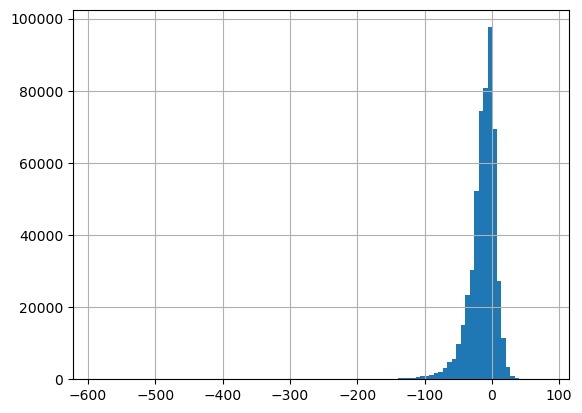

In [13]:
df[predicted_label].hist(bins=100)

In [14]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.203840e+05
mean     3.113723e-01
std      2.271244e-01
min      5.948467e-24
25%      1.176381e-01
50%      2.837764e-01
75%      4.727973e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [15]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST'
#y_col='contcontinuous_transforminuous_transform'

In [16]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [17]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [18]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()

y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

In [19]:
print(y_test[0:40])

[-13. -12. -12. -17. -17. -15. -11.  -8. -12. -16. -14. -14. -14. -15.
 -17. -13. -15. -24. -21. -17. -15. -17. -25. -27. -26. -27. -27. -25.
 -26. -20. -16. -14. -14. -16. -16. -15. -13. -10. -15. -18.]


In [20]:
len(y_test)

104076

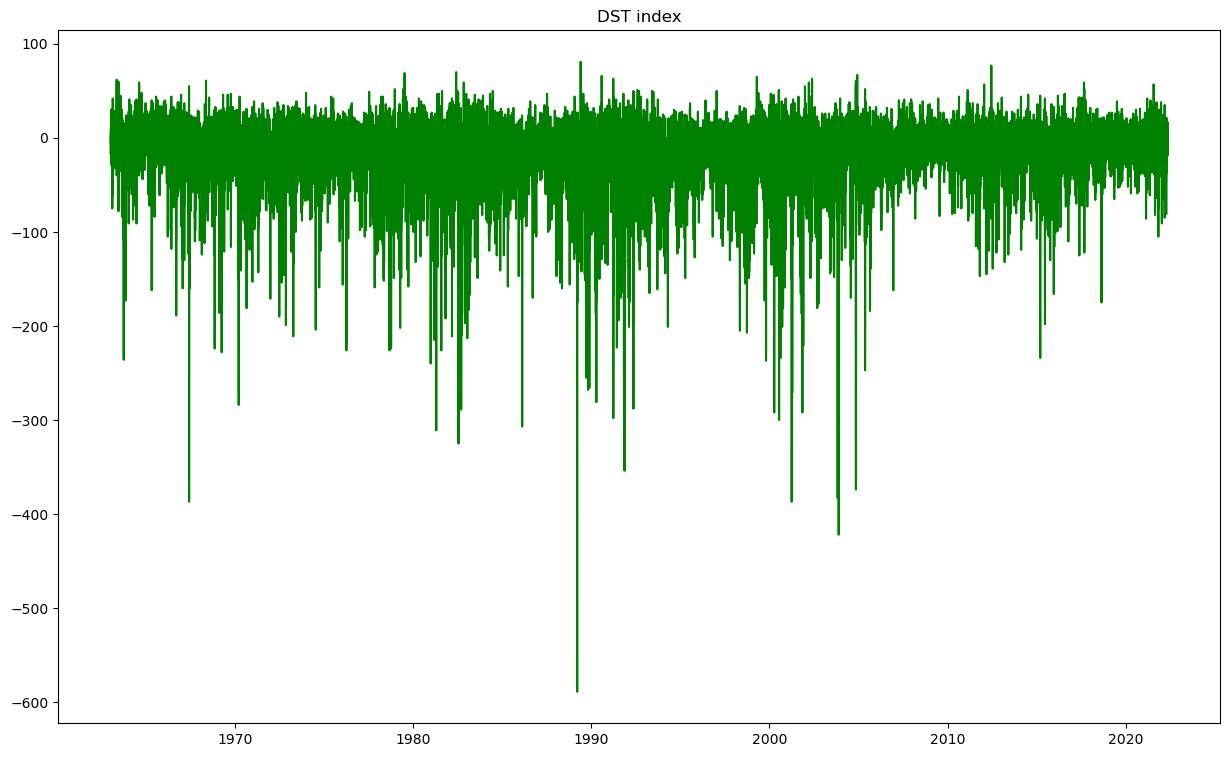

In [21]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index")
plt.plot(train['time1'],train['DST'], color='green')
plt.plot(valid['time1'],valid['DST'], color='green')
plt.plot(test['time1'],test['DST'], color='green')


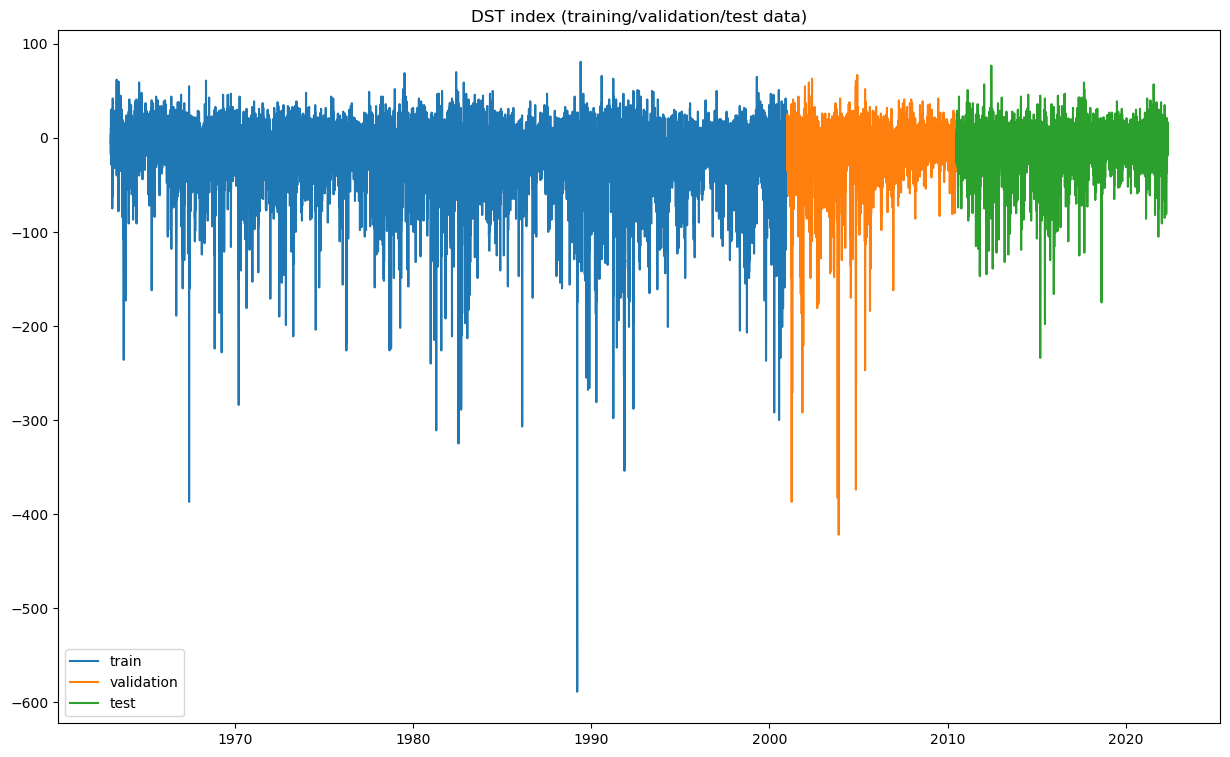

In [22]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [23]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=b_size)

In [ ]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

In [24]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1301
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [25]:
print("Počet batchov: ", len(test_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(test_generator[0]))
print("Dĺžka X zložky batchu: ", len(test_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(test_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(test_generator[0][0][0]))

Počet batchov:  407
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [26]:
print("Počet batchov: ", len(val_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(val_generator[0]))
print("Dĺžka X zložky batchu: ", len(val_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(val_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(val_generator[0][0][0]))

Počet batchov:  326
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [31]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirection  (None, 256)               133120    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [60]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 6, 256)            133120    
 onal)                                                           
                                                                 
 lstm_4 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed_1 (TimeDi  (None, 6, 1)              129       
 stributed)                                                      
                                                                 
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 7   

In [61]:
# callbacks
saved_model = "my_model.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [62]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1, callbacks = callbacks_list)

Epoch 1/10
1301/1301 [==============================] - ETA: 0s - loss: 100.1962 - mae: 4.6750
Epoch 1: val_mae improved from inf to 2.81024, saving model to my_model.hdf5
1301/1301 [==============================] - 43s 30ms/step - loss: 100.1962 - mae: 4.6750 - val_loss: 48.3408 - val_mae: 2.8102
Epoch 2/10
   3/1301 [..............................] - ETA: 34s - loss: 26.3888 - mae: 3.7082

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1301/1301 [==============================] - ETA: 0s - loss: 40.3594 - mae: 3.5844
Epoch 2: val_mae did not improve from 2.81024
1301/1301 [==============================] - 38s 29ms/step - loss: 40.3594 - mae: 3.5844 - val_loss: 35.9079 - val_mae: 2.9461
Epoch 3/10
1301/1301 [==============================] - ETA: 0s - loss: 32.0526 - mae: 3.3365
Epoch 3: val_mae did not improve from 2.81024
1301/1301 [==============================] - 38s 29ms/step - loss: 32.0526 - mae: 3.3365 - val_loss: 30.9549 - val_mae: 2.9273
Epoch 4/10
1301/1301 [==============================] - ETA: 0s - loss: 29.1401 - mae: 3.2497
Epoch 4: val_mae did not improve from 2.81024
1301/1301 [==============================] - 38s 29ms/step - loss: 29.1401 - mae: 3.2497 - val_loss: 31.9890 - val_mae: 2.9754
Epoch 5/10
1301/1301 [==============================] - ETA: 0s - loss: 31.3904 - mae: 3.3035
Epoch 5: val_mae did not improve from 2.81024
1301/1301 [==============================] - 38s 29ms/step - loss: 31.

In [27]:
model = keras.models.load_model('my_model.hdf5')

2024-04-27 10:42:47.335512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 6s 13ms/step


Confusion matrix: 
[[82161  1194]
 [ 2849 17866]]


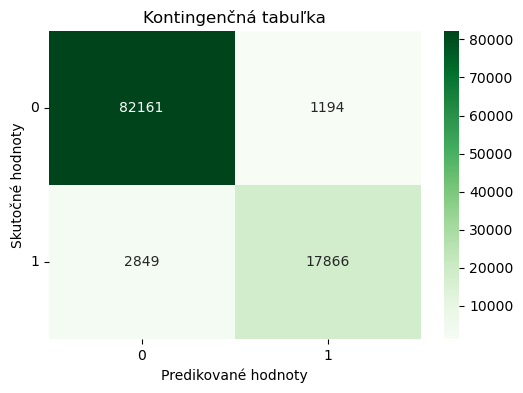

In [29]:
y_pred2 = np.where(y_pred <= -20, 1, 0)
y_test2 = np.where(y_test[n_input:] <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Kontingenčná tabuľka')
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], rotation=0)
plt.show()

In [30]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     83355
           1       0.94      0.86      0.90     20715

    accuracy                           0.96    104070
   macro avg       0.95      0.92      0.94    104070
weighted avg       0.96      0.96      0.96    104070



In [31]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [32]:
df.describe()

,y_true,y_predict
count,104070.000000,104070.000000
mean,-9.640242,-9.407832
std,16.037430,15.021781
min,-234.000000,-127.713211
25%,-17.000000,-16.055652
50%,-7.000000,-6.575965
75%,0.000000,-0.092181
max,77.000000,36.945568


<AxesSubplot:>

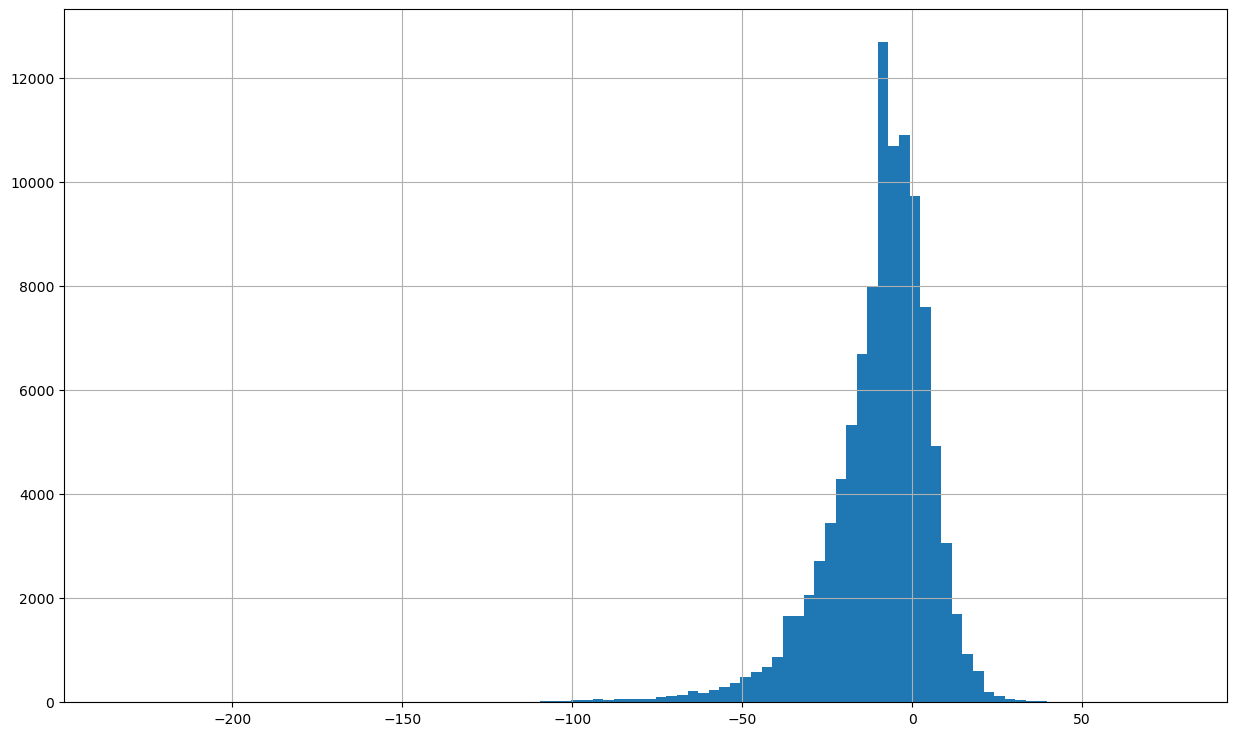

In [33]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

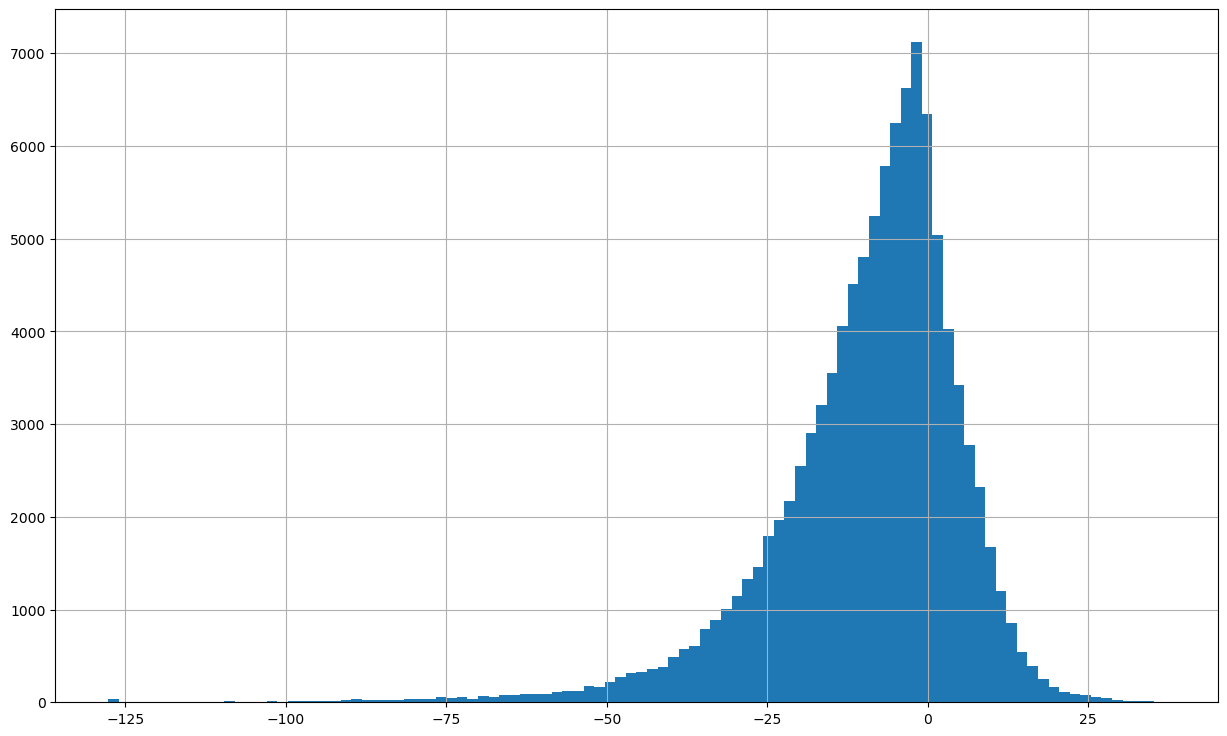

In [34]:
df["y_predict"].hist(bins=100)

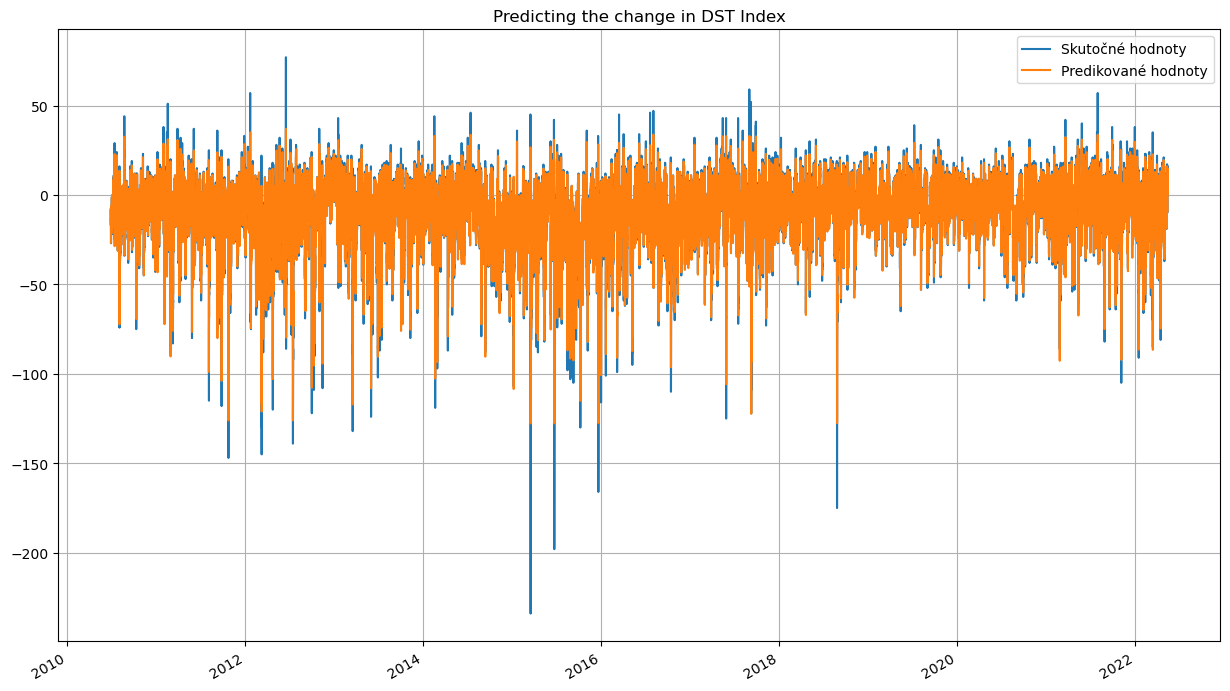

In [35]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [36]:
df.to_csv('predikcie_6h_dozadu_1h_dopredu.csv')

# Vysvetliteľnosť modelu na základe DST indexu 1h dopredu 6 dozadu

In [37]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [38]:
#hodnota pre vypínanie intervalov priemer
value_for_shutdown = np.mean(X_test)
value_for_shutdown

-9.640512702256043

In [39]:
#hodnota pre vypínanie intervalov median
value_for_shutdown_median = np.median(X_test)
value_for_shutdown_median

-7.0

In [40]:
def XAI_for_DST_Prediction(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-5,1)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig

In [41]:
def XAI_for_DST_Prediction_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,2)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+2],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+2, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

1/1 [==============================] - 0s 19ms/step


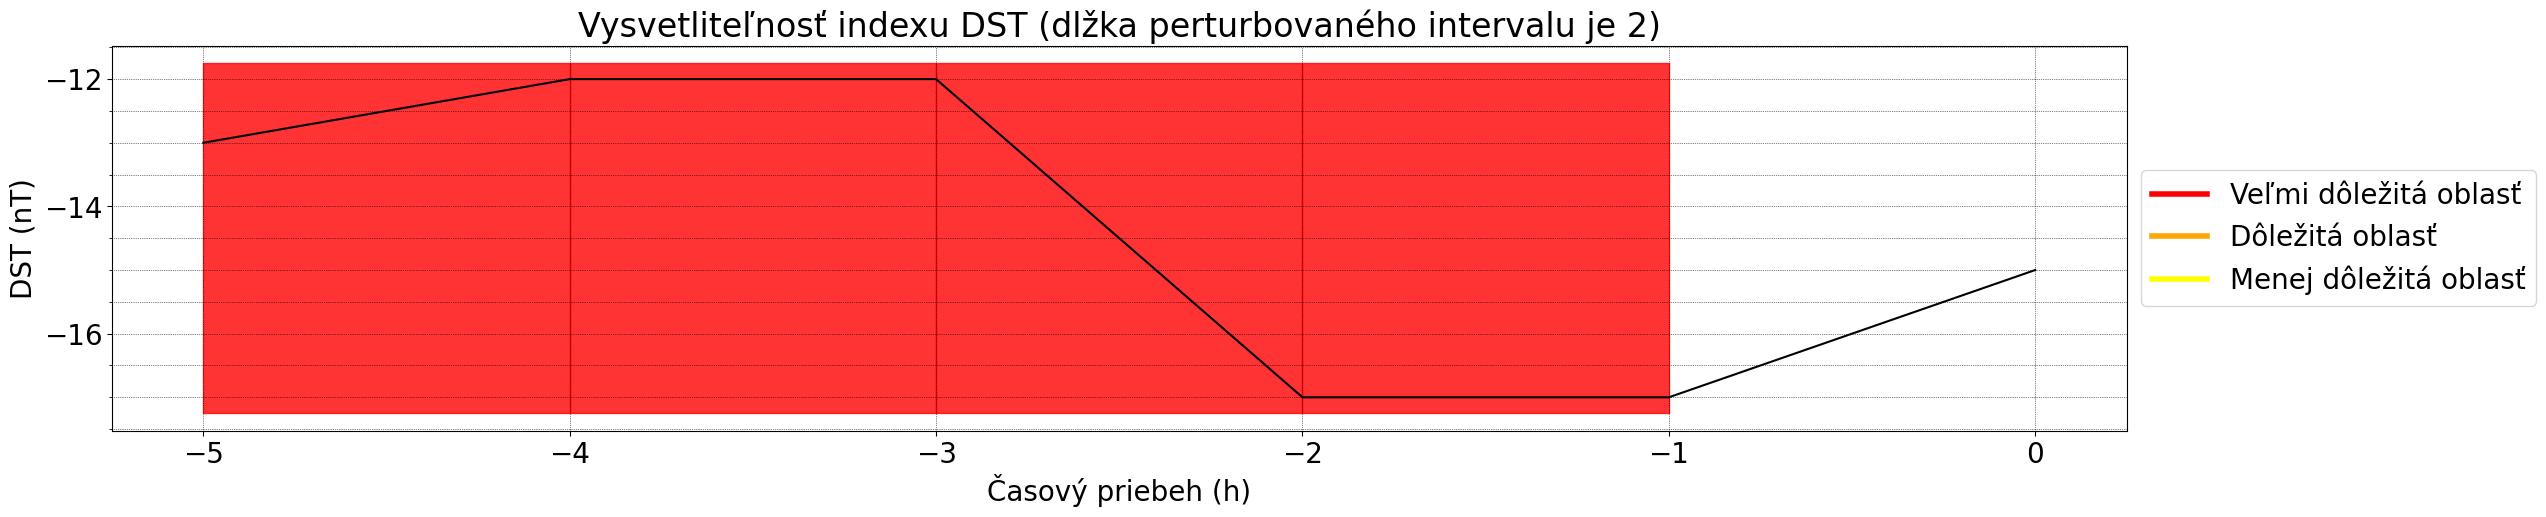

In [42]:
XAI_for_DST_Prediction(test_generator[0][0][0], model,2, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


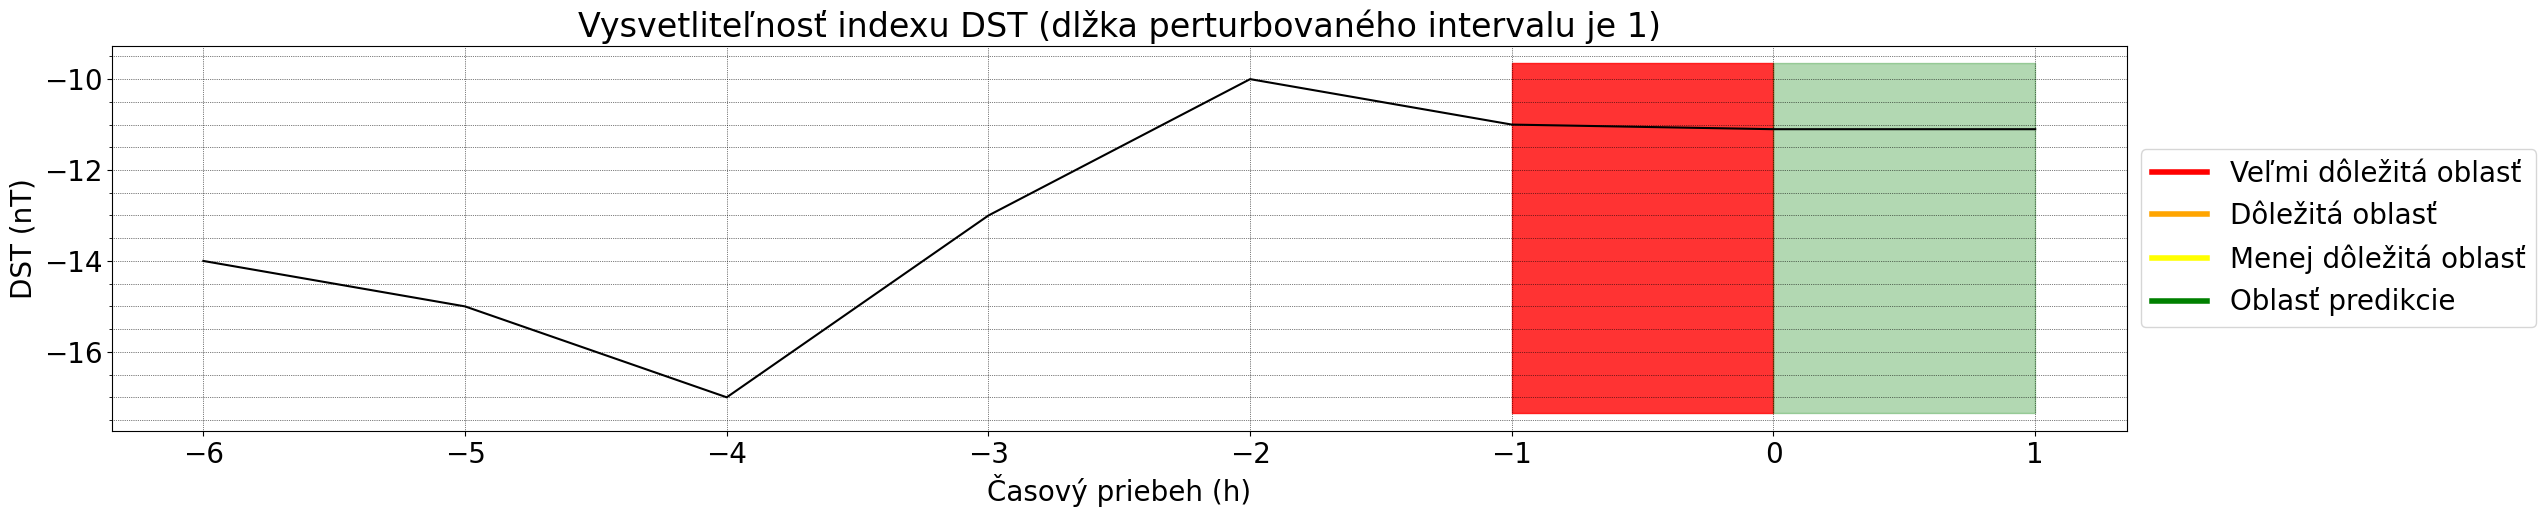

In [43]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][243], model,1, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


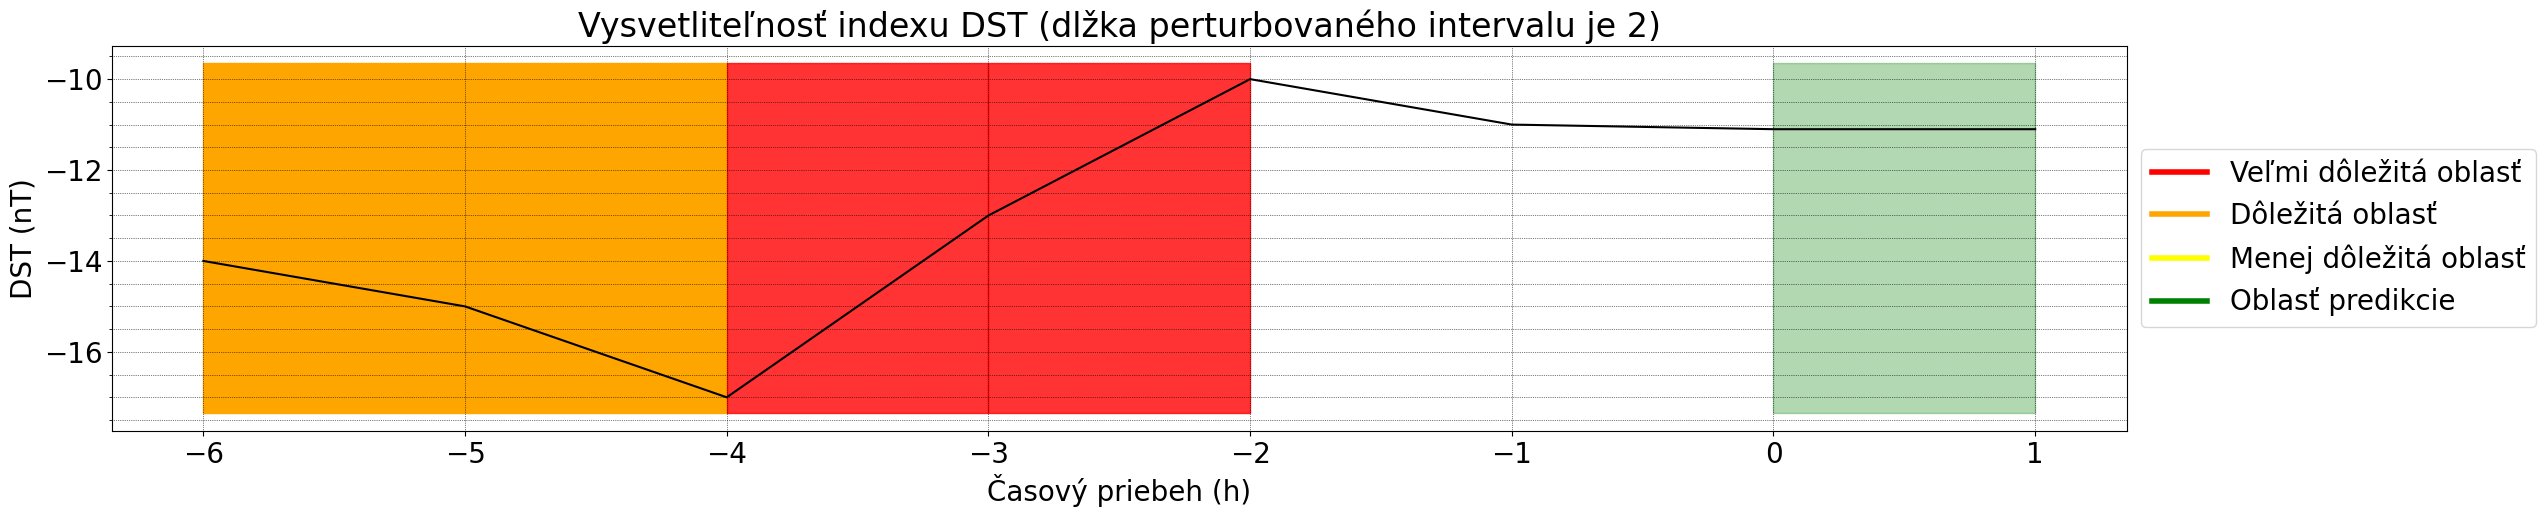

In [44]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][243], model,2, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


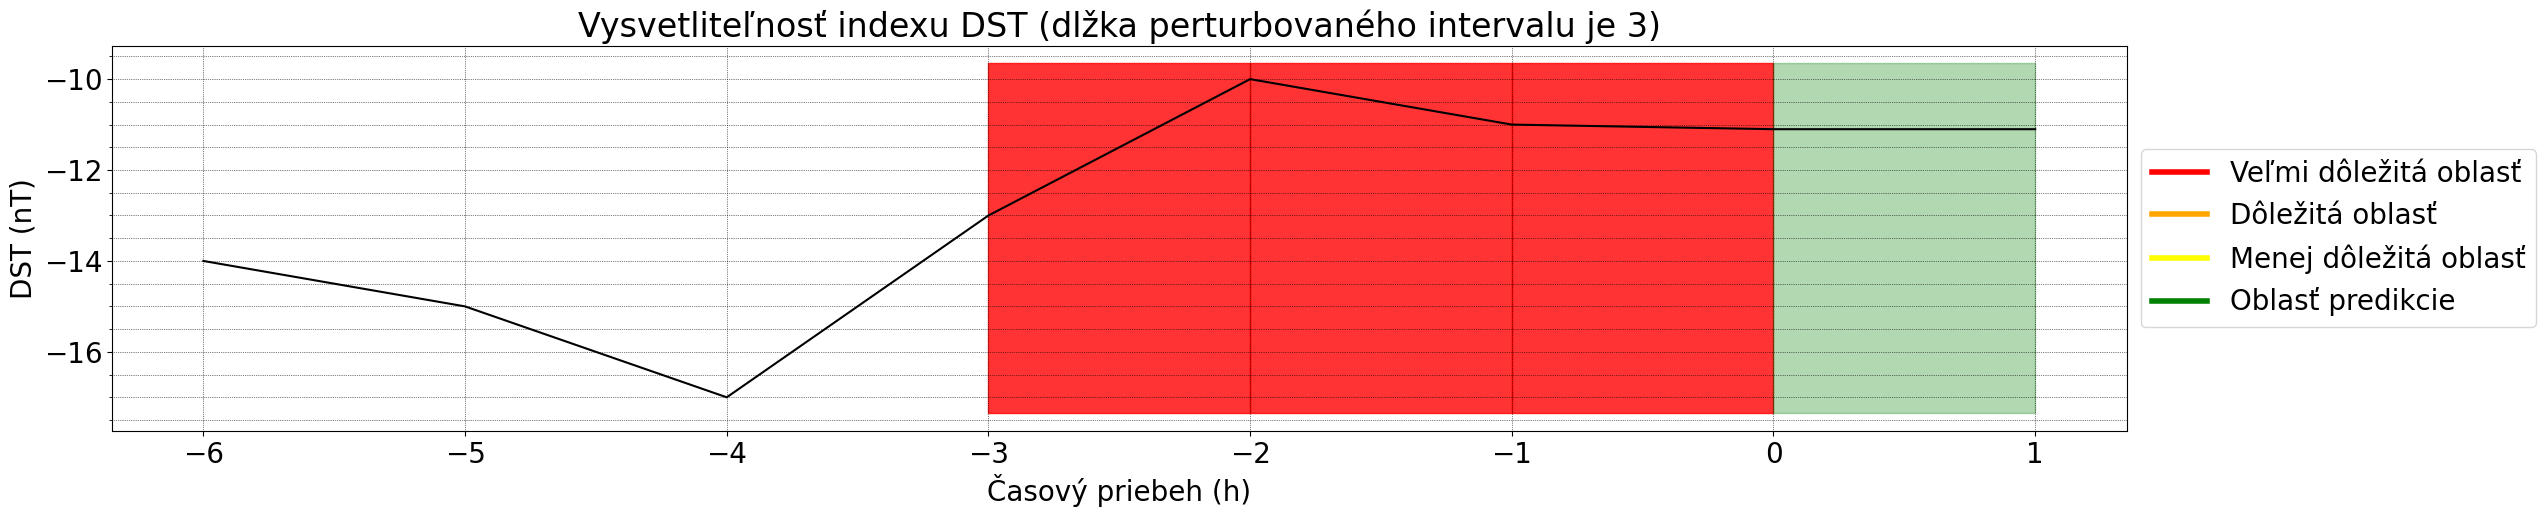

In [45]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][243], model,3, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


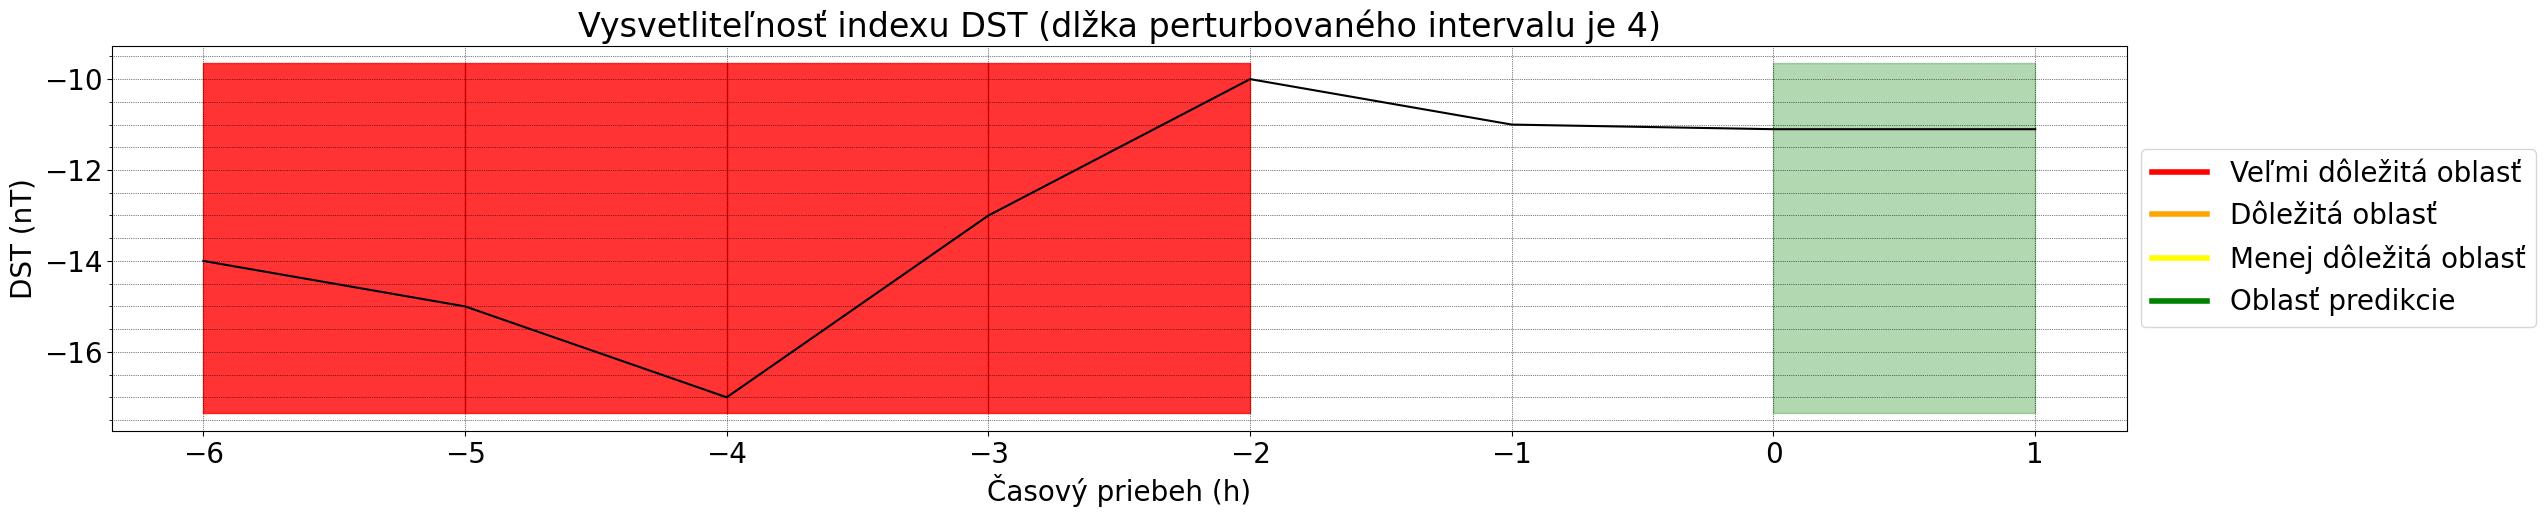

In [46]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][243], model,4, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


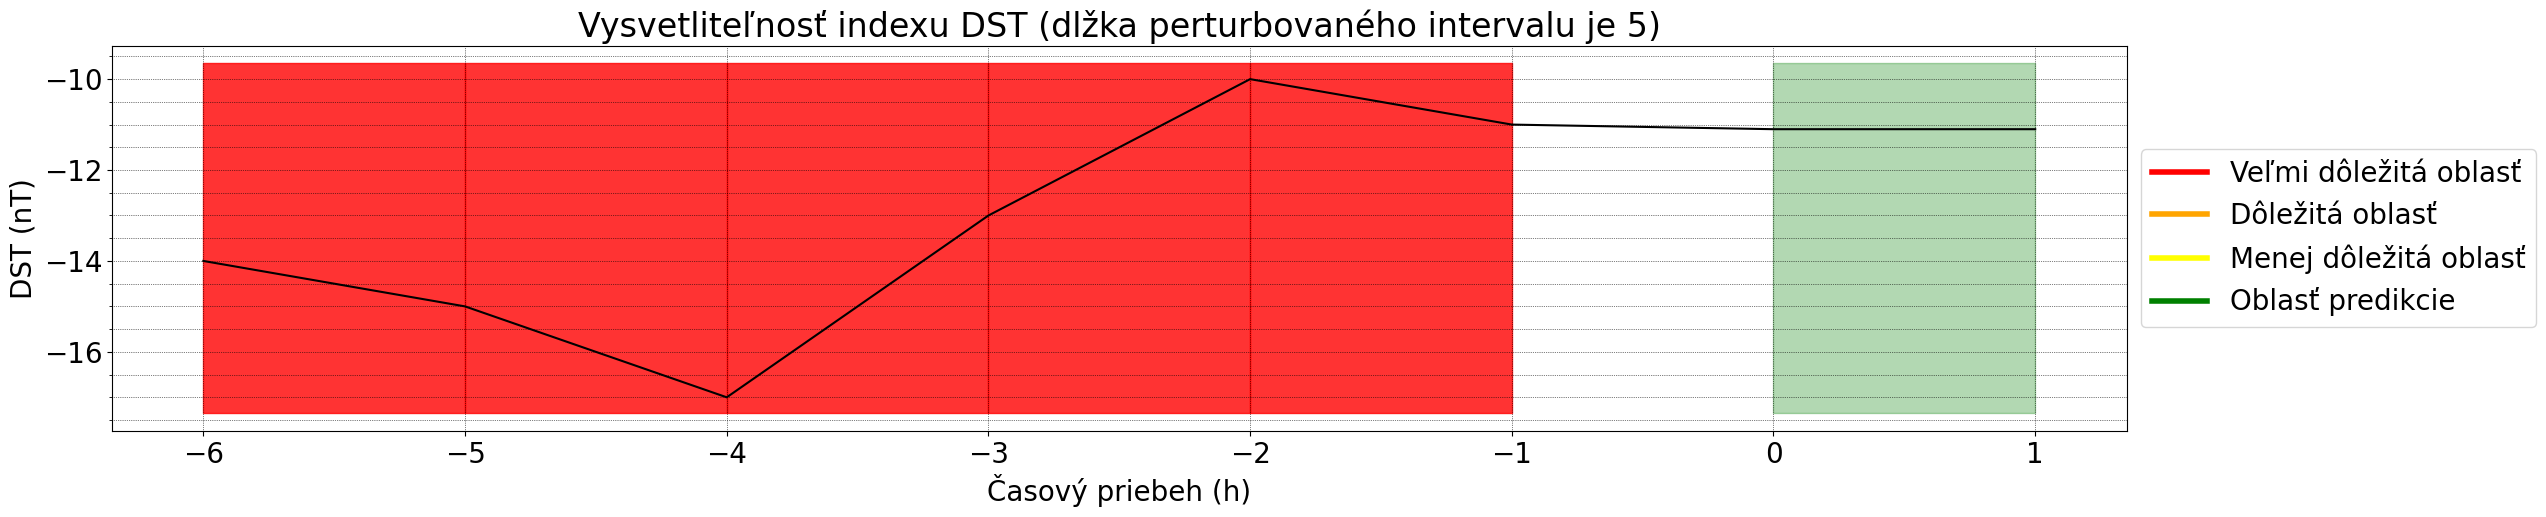

In [47]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][243], model,5, value_for_shutdown)

1/1 [==============================] - 0s 19ms/step


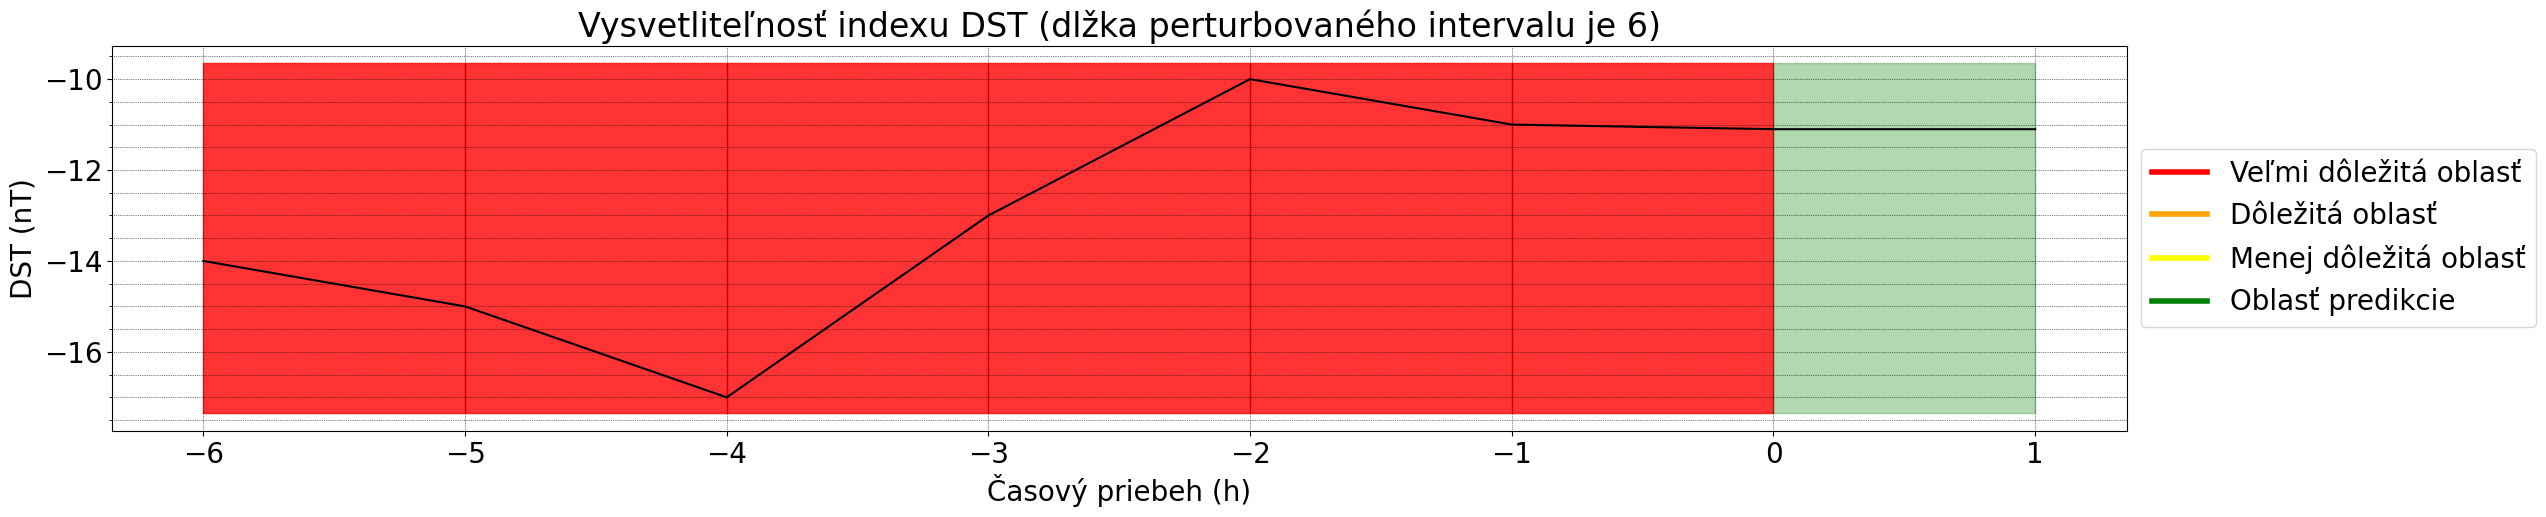

In [48]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][243], model,6, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


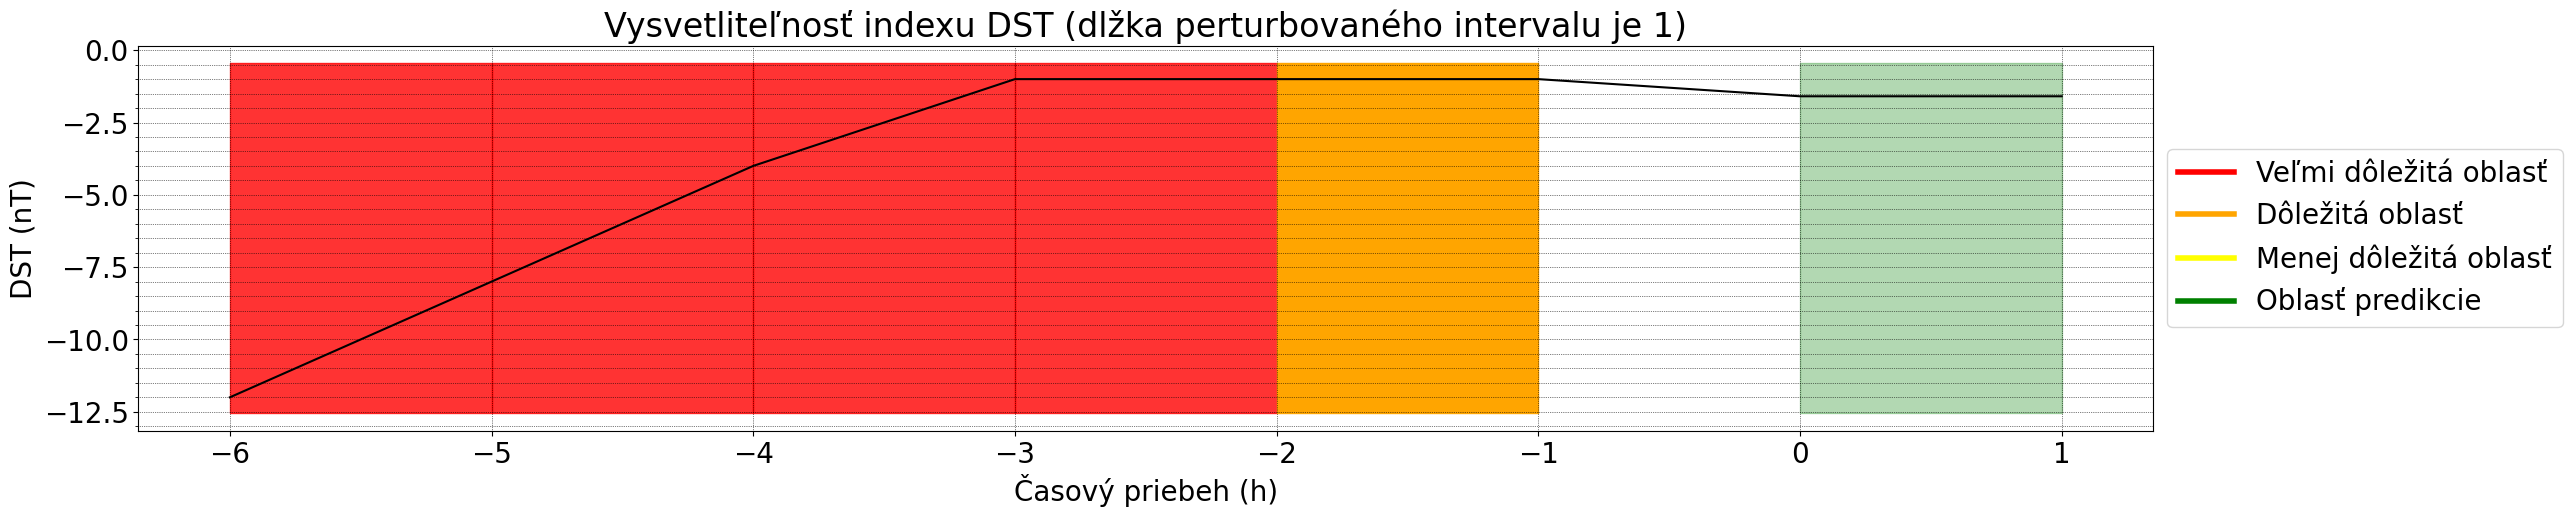

In [49]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][103], model,1, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


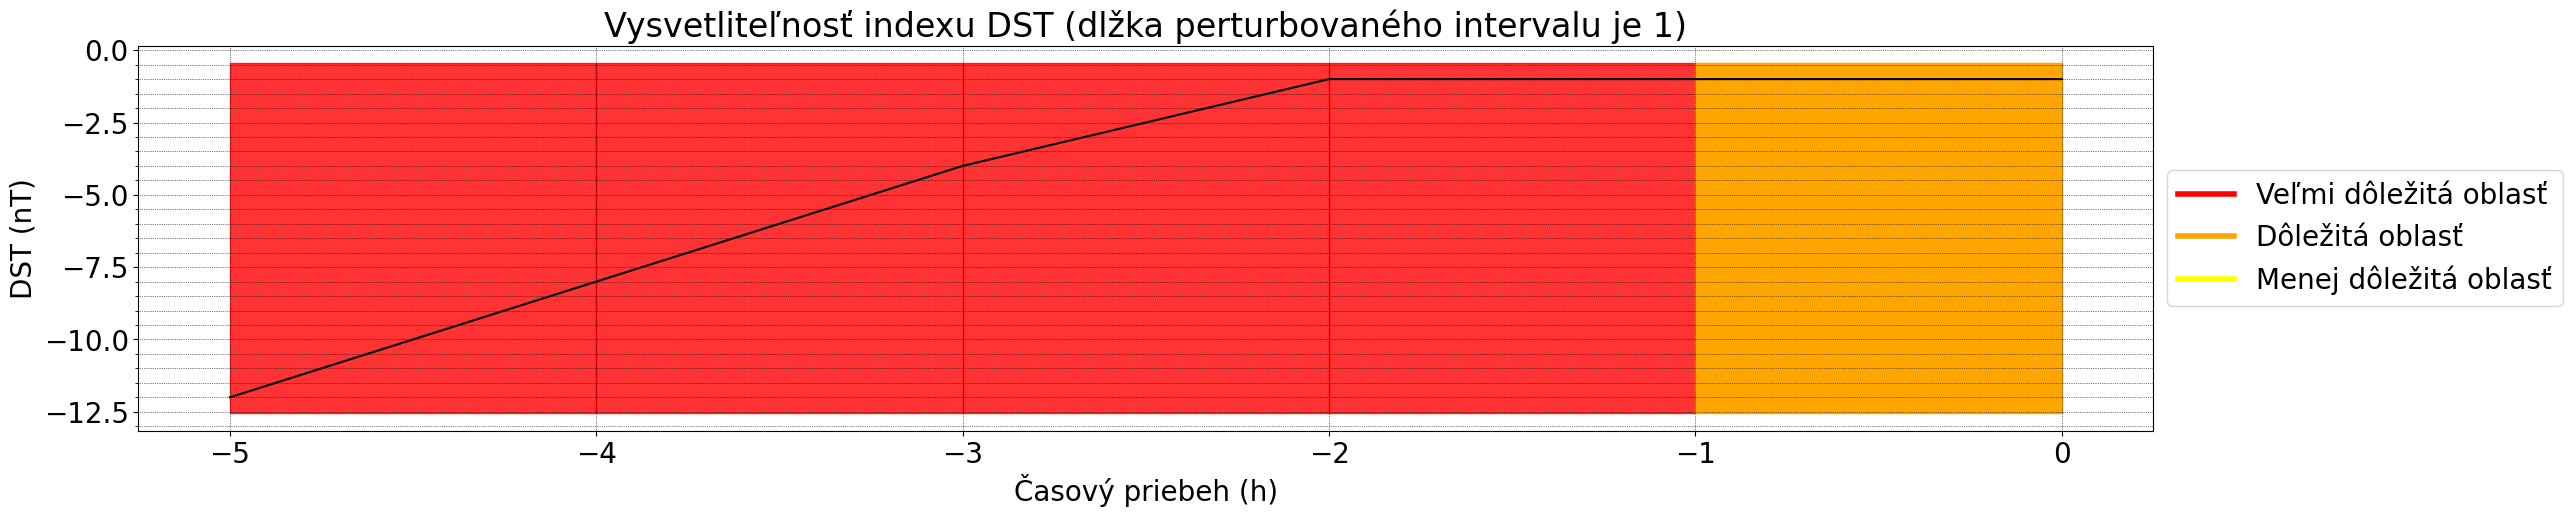

In [51]:
XAI_for_DST_Prediction(test_generator[0][0][103], model,1, value_for_shutdown)

In [52]:
def XAI_for_DST_Prediction_with_predicted_value_for_dashboard(data_instance,data_instance2, model, interval_length, value_for_shutdown,max_range):
    testovacia_vzorka = data_instance.reshape(1,6,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
    
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]

    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    
    # Vizualizácia
    if np.any(data_instance2 != 0):
        dst = data_instance
        dst_new = np.append(dst,data_instance2[-1])
        dst_new = np.append(dst_new,data_instance2[-1])
    else:
        dst = data_instance
        dst_new = np.append(dst,y_pred_single)
        dst_new = np.append(dst_new,y_pred_single)

    time_data = np.arange(8)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:8],color='black')
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(max_range - 7, max_range+1, 1) % 24
    ax.set_xticks(grid_x_ticks , minor=True)
    ax.set_xticklabels(grid_x_ticks)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    if np.any(data_instance2 != 0):
        ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Skutočná oblasť'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    else:
        ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
            
    #plt.axvline(x=6, color='green', linestyle='-', lw=5)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:7] > 0.85) & (audio_scaled1[0:7] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:7] > 0.6) & (audio_scaled1[0:7] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:7] > 0.5) & (audio_scaled1[0:7] <= 0.6), color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where=(time_data >= time_data[-2]) & (time_data <= time_data[-1]), color='green', alpha=0.3)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

# Dashboard zobrazuje reálne a predikované hodnoty DST a taktiež doležitosť intervalov pre pre predikciu novej hodnoty

In [53]:
import ipywidgets as widgets
from ipywidgets import IntSlider, Layout
from IPython.display import display, clear_output
from IPython.display import display, HTML
import datetime

In [54]:
# pred spustením je potrebné postupne spustiť kazdý riadok, trénovanie modelu nie je nutné, stači model načíatať

In [55]:
dashboard_title = widgets.HTML(value="<h1 style='color: green; text-align: left;'>Vysetliteľnosť modelu pre predikciu indexu DST</h1>")
style_html = """
<style>
    .widget-label { font-size: 16px; }
</style>
"""

sequences = []
for x, y in test_generator:
    sequences.extend(x)
    
y_pred = model.predict(test_generator)
    
style = {'description_width': 'initial'}

start_date_widget = widgets.DatePicker(
    description='Zvoľ si dátum sledovania:',
    disabled=False,
    style=style,
    value=datetime.date(2010, 6, 29),
    min=datetime.date(2010, 6, 29),
    max=datetime.date(2022, 5, 14)
)
hours_to_watch_widget = widgets.IntSlider(value=12, min=0, max=24, description='Koľko hodín chceš sledovať:', step=1, style=style)
hours_to_watch_widget.layout = Layout(width='350px', height='40px')
interval_length_widget = widgets.RadioButtons(options=[1, 2, 3],description='Výber dĺžky perturbovaného intervalu:',value=2,disabled=False, style=style)
index_widget = widgets.IntSlider(value=12,description='Výber konkrétnej hodiny počas dňa:', continuous_update=False,min=0,max=24, style=style)        
index_widget.layout = Layout(width='400px', height='40px')

generate_button1 = widgets.Button(description='Generovať graf', button_style='success')
generate_button2 = widgets.Button(description='Generovať graf', button_style='success')

output_container1 = widgets.Output()
output_container2 = widgets.Output()

def on_generate_button_clicked1(b):
    
    selected_date = start_date_widget.value
    start_index = (selected_date - datetime.date(2010, 6, 29)).days    
    start_index = max(0, start_index) 
    index = index_widget.value
    interval_length = interval_length_widget.value
    hours_to_watch = hours_to_watch_widget.value
    
    if start_index == 0:
        start_index = start_index*24
        fig1 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index-11],0, model, interval_length, value_for_shutdown,index)
        fig1.suptitle('Vybrané časové okno s predikovanou hodnotou',fontsize = 24)
        fig2 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index-11],sequences[start_index+index-11+1], model, interval_length, value_for_shutdown,index)
        fig2.suptitle('Vybrané časové okno so skutočnou hodnotou', fontsize = 24)
    else:
        start_index = (start_index*24)-11
        fig1 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index],0, model, interval_length, value_for_shutdown,index)
        fig1.suptitle('Vybrané časové okno s predikovanou hodnotou', fontsize = 24)
        fig2 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index],sequences[start_index+index+1], model, interval_length, value_for_shutdown,index)
        fig2.suptitle('Vybrané časové okno so skutočnou hodnotou', fontsize = 24)
    
    with output_container1:
        clear_output(wait=True)
        display(fig2)
        display(fig1)
        
def on_generate_button_clicked2(b):

    selected_date = start_date_widget.value
    start_index = (selected_date - datetime.date(2010, 6, 29)).days    
    start_index = max(0, start_index) 
    hours_to_watch = hours_to_watch_widget.value
    last_elements = []
    elements = []
    start_index2 = 0
    start_index1 = 0
    hours_to_watch1 = hours_to_watch
    hours_to_watch2 = hours_to_watch
    
    if start_index == 0:
        hours_to_watch1 = 14
        start_index1 = 1
    elif start_index == 4336:
        start_index1 = (start_index*24)-10
        hours_to_watch1 = 16
    else:
        start_index1 = (start_index*24)-10
    
    for i in range(start_index1,start_index1+hours_to_watch1):
        last_elements.append(sequences[i][-1])

    fig3 = plt.figure(figsize=(26, 3))
    if start_index == 0:
        plt.plot(range(11, 11 + len(last_elements)), last_elements, marker='o', c='green')
        plt.xticks(range(11, 11 + hours_to_watch1))
    else:
        plt.plot(last_elements, marker='o', c='green')
        plt.xticks(range(hours_to_watch1)) 
        
    plt.title('Skutošné hodnoty DST na ' + str(hours_to_watch1) + "-hodinovom okne",fontsize=25)
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.yticks(fontsize=15)
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    
    if start_index == 0:
        start_index2 = 0
        hours_to_watch2 = 14
    elif start_index == 4336:
        start_index2 = (start_index*24)-11
        hours_to_watch2 = 17
    else:
        start_index2 = (start_index*24)-11
    
    for i in range(start_index2,start_index2+hours_to_watch2):
        elements.append(y_pred[i])
    
    fig4 = plt.figure(figsize=(26, 3))
    if start_index == 0:
        plt.plot(range(11, 11 + len(elements)), elements, marker='o', c='green')
        plt.xticks(range(11, 11 + hours_to_watch2))
    else:
        plt.plot(elements, marker='o', c='green')
        plt.xticks(range(hours_to_watch2))
    
    plt.title('Predikované hodnoty DST na '+ str(hours_to_watch2)+ "-hodinovom okne", fontsize=25)
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.yticks(fontsize=15)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    
    with output_container2:
        clear_output(wait=True)
        display(fig4)
        display(fig3)

generate_button1.on_click(on_generate_button_clicked1)
generate_button2.on_click(on_generate_button_clicked2)

display(HTML(style_html), dashboard_title, start_date_widget, hours_to_watch_widget, generate_button2, output_container2, index_widget,interval_length_widget,generate_button1,output_container1)


407/407 [==============================] - 6s 14ms/step


HTML(value="<h1 style='color: green; text-align: left;'>Vysetliteľnosť modelu pre predikciu indexu DST</h1>")

DatePicker(value=datetime.date(2010, 6, 29), description='Zvoľ si dátum sledovania:', max=datetime.date(2022, …

IntSlider(value=12, description='Koľko hodín chceš sledovať:', layout=Layout(height='40px', width='350px'), ma…

Button(button_style='success', description='Generovať graf', style=ButtonStyle())

Output()

IntSlider(value=12, continuous_update=False, description='Výber konkrétnej hodiny počas dňa:', layout=Layout(h…

RadioButtons(description='Výber dĺžky perturbovaného intervalu:', index=1, options=(1, 2, 3), style=Descriptio…

Button(button_style='success', description='Generovať graf', style=ButtonStyle())

Output()

In [68]:
len(test)

104076

# Dôležité dni kedy DST kleslo pod hodnotu -150

In [56]:
important_dates = []

for index, row in df.iterrows():
    if row['y_true'] < -150:
        date = pd.to_datetime(row['time']).date()
        important_dates.append(date)

important_dates = list(set(important_dates))

print(important_dates)

[datetime.date(2015, 3, 18), datetime.date(2015, 12, 20), datetime.date(2015, 3, 17), datetime.date(2015, 6, 23), datetime.date(2018, 8, 26), datetime.date(2015, 12, 21)]


# Analýza 

In [57]:
sequence = []
for x, y in test_generator:
    sequence.extend(x)

In [58]:
len(sequence)

104070

In [59]:
before_2012 = df[df['time'].dt.year < 2012]
after_2017 = df[df['time'].dt.year <= 2017]

count1 = before_2012.shape[0]
count2 = after_2017.shape[0]
count1


13213

In [60]:
count2

65821

# Časové okná pre analýzu 

In [ ]:
for i in range(13214, 65821):
    if abs(sequence[i][5] - sequence[i][0]) >= 50:
        # Zistí, či sekvencia obsahuje prvky na oboch stranách -20
        above = any(x >= -20 for x in sequence[i])
        below = any(x < -20 for x in sequence[i])
        if above and below:
            print(sequence[i])


In [61]:
# vytvorenie pričinku ak neexistuje
image_direction1 = "images_for_analysis_perturb1_test_6_1"
os.makedirs(image_direction1, exist_ok=True)

In [62]:
# vytvorenie pričinku ak neexistuje
image_direction2 = "images_for_analysis_perturb2_test_6_1"
os.makedirs(image_direction2, exist_ok=True)

In [63]:
# vytvorenie pričinku ak neexistuje
image_direction3 = "images_for_analysis_perturb3_test_6_1"
os.makedirs(image_direction3, exist_ok=True)

In [66]:
for i in range(13214, 65821):
    if abs(sequence[i][5] - sequence[i][0]) >= 50:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])

        if over_the_border and below_the_border:
            fig = XAI_for_DST_Prediction_with_predicted_value(sequence[i], model, 3, value_for_shutdown)
            file_path = os.path.join(image_direction3, f"image_{i}.jpg") 
            fig.savefig(file_path, dpi=50, bbox_inches='tight') 
            #fig.savefig(file_path)
            plt.close(fig)

1/1 [==============================] - 0s 18ms/step
